In [1]:
"""
Motif Conservation Analysis Pipeline

1. Pick a latent you like to do an initial experiment on (eventually do all)
2. Find the top 100 activations across all proteins. So even if there's multiple highly activated residues in one protein, take all of them. Note down the position of each of the top activations and note down which protein
3. For each top activating residue, get the neighborhood of residues (say +- 10 just for example)
4. It is already aligned because the central residue in each neighborhood is a max activated residues
5. Make the sequence logo as per the wiki link I sent, with the central residue of the logo being the residue that "seeded" the neighborhood due to its being in the top-100 most highly activated residues

Important Notes:
- Protein language models add special tokens (BOS/EOS), so token positions != residue positions
- Token 0: <cls>/<bos>, Tokens 1 to N: amino acids, Token N+1: <eos>
- We properly map token indices to residue indices and handle padding for incomplete neighborhoods
"""


import sys
sys.path.append('../plm_circuits')

import torch
import numpy as np
import json
import time
import os
import random
import pandas as pd
import string
from tqdm import tqdm
from scipy.sparse import csr_matrix, save_npz, load_npz
from Bio import SeqIO
import pathlib
import heapq
from collections import namedtuple
import pickle
import logomaker
import matplotlib.pyplot as plt
# Import utility functions
from helpers.utils import load_esm, load_sae_prot, cleanup_cuda
from hook_manager import SAEHookProt

from enrich_act import load_cached_activations, EfficientActivationCache

In IPython
Set autoreload


In [2]:
# All helpers here 

# Define a named tuple to store activation information
ActivationInfo = namedtuple('ActivationInfo', ['activation_value', 'protein_idx', 'token_idx', 'protein_id', 'residue_idx'])


def find_top_k_activations_streamlined(cache_system, layer_idx, latent_idx, k=100):
    """
    Streamlined approach: single pass, one max per protein, top K globally.
    """
    print(f"Finding top {k} activations for layer {layer_idx}, latent {latent_idx}...")
    print("Using streamlined single-pass approach (one max per protein)")
    
    # Use a min-heap to efficiently maintain top-K
    top_k_heap = []
    
    for protein_idx in tqdm(range(len(cache_system.metadata['proteins'])), desc="Processing proteins"):
        try:
            protein_data = cache_system.metadata['proteins'][protein_idx]
            protein_id = protein_data['protein_id']
            sequence_length = protein_data['sequence_length']
            
            # Load the specific layer file
            layer_file = protein_data[f'layer_{layer_idx}_file']
            
            if cache_system.use_sparse:
                sparse_matrix = load_npz(layer_file)
                latent_column = sparse_matrix[:, latent_idx].toarray().flatten()
            else:
                acts_np = np.load(layer_file)
                latent_column = acts_np[:, latent_idx]
            
            # # Find max activation and its position
            # if len(latent_column) > 0:
            #     valid_length = min(len(latent_column), sequence_length)
            #     valid_activations = latent_column[:valid_length]
                
            #     if len(valid_activations) > 0:
            max_idx = np.argmax(latent_column)
            max_activation = float(latent_column[max_idx])
            
            activation_info = ActivationInfo(
                activation_value=max_activation,
                protein_idx=protein_idx,
                token_idx=max_idx + 1,  # +1 for BOS token offset
                protein_id=protein_id,
                residue_idx=max_idx  # Direct residue position
            )
            
            # Maintain top-K using heap
            if len(top_k_heap) < k:
                heapq.heappush(top_k_heap, (-max_activation, protein_idx, activation_info))
            elif max_activation > -top_k_heap[0][0]:
                heapq.heapreplace(top_k_heap, (-max_activation, protein_idx, activation_info))
                
        except Exception as e:
            print(f"Error processing protein {protein_idx}: {e}")
            continue
    
    # Extract results and sort by activation value (highest first)
    top_k_activations = [item[2] for item in top_k_heap]
    top_k_activations.sort(key=lambda x: x.activation_value, reverse=True)
    
    print(f"\nResults:")
    print(f"- Processed {len(cache_system.metadata['proteins'])} proteins")
    print(f"- Found {len(top_k_activations)} top activations")
    if top_k_activations:
        print(f"- Activation range: {top_k_activations[0].activation_value:.4f} to {top_k_activations[-1].activation_value:.4f}")
    
    return top_k_activations

def extract_neighborhoods(top_activations, protein_sequences, window_size=10, pad_token='X'):
    """
    Extract amino acid neighborhoods around top activating positions.
    Handles proper token-to-residue mapping and pads incomplete neighborhoods.
    
    Args:
        top_activations: List of ActivationInfo tuples
        protein_sequences: Dict mapping protein_id to sequence string
        window_size: Number of residues on each side of the central residue
        pad_token: Token to use for padding when neighborhood extends beyond sequence
    
    Returns:
        List of dicts containing neighborhood information
    """
    neighborhoods = []
    
    for i, act_info in enumerate(tqdm(top_activations, desc="Extracting neighborhoods")):
        protein_id = act_info.protein_id
        residue_idx = act_info.residue_idx - 1 # Use residue index, not token index
        
        if protein_id not in protein_sequences:
            print(f"Warning: Protein {protein_id} not found in sequence database")
            continue
        
        sequence = protein_sequences[protein_id]
        
        # Validate that residue_idx is within the sequence
        if residue_idx >= len(sequence) or residue_idx < 0:
            print(f"Warning: Residue index {residue_idx} out of bounds for protein {protein_id} (length {len(sequence)})")
            continue
        
        # Calculate desired neighborhood boundaries
        desired_start = residue_idx - window_size
        desired_end = residue_idx + window_size + 1
        
        # Calculate actual sequence boundaries
        seq_start = max(0, desired_start)
        seq_end = min(len(sequence), desired_end)
        
        # Extract the actual sequence part
        actual_seq = sequence[seq_start:seq_end]
        
        # Calculate padding needed
        left_padding = seq_start - desired_start  # How many positions we're missing on the left
        right_padding = desired_end - seq_end     # How many positions we're missing on the right
        
        # Create the full neighborhood with padding
        neighborhood_seq = (pad_token * left_padding) + actual_seq + (pad_token * right_padding)
        
        # The central residue is always at position window_size in the padded sequence
        central_pos_in_neighborhood = window_size
        
        neighborhood_info = {
            'rank': i + 1,
            'activation_value': act_info.activation_value,
            'protein_idx': act_info.protein_idx,
            'protein_id': protein_id,
            'token_idx': act_info.token_idx,  # Keep original token index for reference
            'residue_idx': residue_idx,       # Actual amino acid position in sequence
            'central_residue': sequence[residue_idx],
            'neighborhood_seq': neighborhood_seq,
            'neighborhood_length': len(neighborhood_seq),
            'central_pos_in_neighborhood': central_pos_in_neighborhood,
            'full_seq_length': len(sequence),
            'left_padding': left_padding,
            'right_padding': right_padding,
            'actual_start_in_sequence': seq_start,
            'actual_end_in_sequence': seq_end
        }
        
        neighborhoods.append(neighborhood_info)
    
    return neighborhoods

def analyze_conservation(aligned_sequences, positions_to_analyze=None):
    """
    Perform basic conservation analysis on aligned sequences.
    
    Args:
        aligned_sequences: List of aligned amino acid sequences
        positions_to_analyze: List of positions to analyze (None for all)
    
    Returns:
        position_frequencies: Dict of position -> amino acid -> count
    """
    if not aligned_sequences:
        return {}
    
    seq_length = len(aligned_sequences[0])
    position_frequencies = {}
    
    # Analyze all positions if none specified
    if positions_to_analyze is None:
        positions_to_analyze = list(range(seq_length))
    
    for pos in positions_to_analyze:
        position_frequencies[pos] = {}
        
        for seq in aligned_sequences:
            if pos < len(seq):
                aa = seq[pos]
                position_frequencies[pos][aa] = position_frequencies[pos].get(aa, 0) + 1
    
    return position_frequencies

def prepare_logomaker_data(conservation_data, aligned_sequences):
    """
    Convert conservation data to format needed for logomaker.
    
    Args:
        conservation_data: Dict from analyze_conservation
        aligned_sequences: List of aligned sequences
        
    Returns:
        pandas DataFrame with amino acids as rows and positions as columns
    """
    
    if not aligned_sequences or not conservation_data:
        return None
    
    seq_length = len(aligned_sequences[0])
    
    # All 20 standard amino acids (excluding X for now)
    amino_acids = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 
                   'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']
    
    # Use simple integer positions for logomaker (it doesn't like multi-character column names)
    positions = list(range(seq_length))
    
    # Initialize count matrix with integer positions
    count_matrix = pd.DataFrame(0, index=amino_acids, columns=positions)
    
    # Fill in the counts
    for pos in range(seq_length):
        if pos in conservation_data:
            for aa, count in conservation_data[pos].items():
                if aa in amino_acids:  # Skip X (padding) for cleaner logo
                    count_matrix.loc[aa, pos] = count
    
    return count_matrix


In [3]:

tmp = load_cached_activations('/project/pi_annagreen_umass_edu/jatin/plm_circuits/acts')
test_protein = tmp.load_protein_activations_original_format(0)
print(test_protein)

# Load protein sequences from FASTA file to get actual amino acid sequences
FASTA_PATH = pathlib.Path("../../plm_interp/uniprot_sprot.fasta")
print("Loading protein sequences...")
protein_sequences = {}
for rec in SeqIO.parse(FASTA_PATH, "fasta"):
    if len(rec.seq) <= 1022:  # Same filter as used in the activation cache
        protein_sequences[rec.id] = str(rec.seq)

print(f"Loaded {len(protein_sequences)} protein sequences")

Loaded cache with 10000 proteins
{'protein_id': 'sp|Q5B136|EIF3J_EMENI', 'sequence_length': 265, 'activations': {4: tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]), 8: tensor([[0.0000, 0.0000, 3.1250,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]), 12: tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.7837],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0

# 1. getting top (protein, residue) pairs

In [4]:
# %% 1. Finding top (protein, residue) pairs
layer_idx = 4
latent_idx = 3788
top_k = 100
window_size = 10
load_from_cache = False

if load_from_cache:
    with open(f'top_activations_layer{layer_idx}_latent{latent_idx}_top{top_k}_streamlined.pkl', 'rb') as f:
        top_activations = pickle.load(f)
else: 
# Find top K activations across all proteins (using streamlined approach)
    top_activations = find_top_k_activations_streamlined(
        tmp, layer_idx, latent_idx, k=top_k
    )
    with open(f'top_activations_layer{layer_idx}_latent{latent_idx}_top{top_k}_streamlined.pkl', 'wb') as f:
        pickle.dump(top_activations, f)

non_zero_activations = [act for act in top_activations if act.activation_value > 0.05]
print(len(non_zero_activations))
print(top_activations[0])

Finding top 100 activations for layer 4, latent 3788...
Using streamlined single-pass approach (one max per protein)


Processing proteins:   0%|          | 0/10000 [00:00<?, ?it/s]

Processing proteins: 100%|██████████| 10000/10000 [15:51<00:00, 10.51it/s]


Results:
- Processed 10000 proteins
- Found 100 top activations
- Activation range: 5.4141 to 0.0000
99
ActivationInfo(activation_value=5.4140625, protein_idx=2274, token_idx=4, protein_id='sp|B1JIX0|RS17_YERPY', residue_idx=3)


In [14]:
neighborhoods = extract_neighborhoods(non_zero_activations, protein_sequences, window_size=window_size)

print(f"\nExtracted {len(neighborhoods)} neighborhoods")

# Display first few neighborhoods
print("\nTop 10 neighborhoods:")
for i, neighborhood in enumerate(neighborhoods[:10]):
    central_res = neighborhood['central_residue']
    seq = neighborhood['neighborhood_seq']
    central_pos = neighborhood['central_pos_in_neighborhood']
    act_val = neighborhood['activation_value']
    residue_pos = neighborhood['residue_idx']
    token_pos = neighborhood['token_idx']
    
    # Create a visual representation with the central residue highlighted
    seq_display = seq[:central_pos] + f"[{central_res}]" + seq[central_pos+1:]
    
    # Show both residue position (in sequence) and token position (in model)
    print(f"{i+1:2d}. Act={act_val:.4f}, {neighborhood['protein_id']}, residue_pos={residue_pos} (token={token_pos}): {seq_display}")
    
    # Show padding info if any
    if neighborhood['left_padding'] > 0 or neighborhood['right_padding'] > 0:
        print(f"    Padding: {neighborhood['left_padding']} left, {neighborhood['right_padding']} right")

Extracting neighborhoods: 100%|██████████| 99/99 [00:00<00:00, 137268.13it/s]


Extracted 98 neighborhoods

Top 10 neighborhoods:
 1. Act=5.4141, sp|B1JIX0|RS17_YERPY, residue_pos=2 (token=4): XXXXXXXXMT[D]QIRTLQGRVV
    Padding: 8 left, 0 right
 2. Act=4.3945, sp|Q1E6Q0|CMR1_COCIM, residue_pos=233 (token=235): ESDEEDEYPD[P]TITTIKPHTN
 3. Act=4.3828, sp|Q07521|OPI6_YEAST, residue_pos=66 (token=68): SVTIKGLTGP[C]LISSSGTGSS
 4. Act=4.3711, sp|Q92HD2|Y839_RICCN, residue_pos=46 (token=48): LPQYLANKEY[Q]KIDKQKFNSH
 5. Act=4.3398, sp|Q6ZLB0|RSBZ1_ORYSJ, residue_pos=143 (token=145): LATVAMWRAS[G]AIHSESPLGN
 6. Act=4.2031, sp|P54621|BUK_GEOSE, residue_pos=5 (token=7): XXXXXMQEQK[F]RILTINPGST
    Padding: 5 left, 0 right
 7. Act=4.1484, sp|Q3K429|MNME_PSEPF, residue_pos=451 (token=453): DDLLGRIFSS[F]CIGKXXXXXX
    Padding: 0 left, 6 right
 8. Act=4.1133, sp|Q87KT0|PUR9_VIBPA, residue_pos=430 (token=432): CWKVAKYVKS[N]AIVYAKGDMT
 9. Act=4.0273, sp|Q7MN30|QUEF_VIBVY, residue_pos=146 (token=148): TQQPIVTMEG[E]CIDEQDIDIS
10. Act=4.0117, sp|B7LFG6|TRHO_ECO55, residue_pos=5 (to

In [9]:
test_protein = tmp.load_protein_activations_original_format(non_zero_activations[0].protein_idx)
print(test_protein['activations'][4][:, latent_idx])

tensor([0.0000, 0.0000, 0.0000, 5.4141, 0.0000, 0.0000, 1.6387, 0.0000, 0.0000,
        0.0000, 1.9424, 1.8057, 0.9424, 0.0000, 0.0000, 1.4707, 0.0000, 0.0000,
        0.0000, 1.6035, 1.6064, 1.4385, 0.0000, 3.6445, 0.0000, 0.0000, 1.4141,
        1.4248, 0.0000, 0.0000, 0.0000, 4.1016, 0.0000, 0.0000, 0.0000, 0.0000,
        3.5410, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.1084, 0.0000, 1.3301,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 3.4570,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 3.5938, 0.0000, 0.0000, 0.0000,
        0.8135, 0.0000, 0.0000, 0.8740, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 1.0996, 0.0000, 0.0000, 1.0566, 0.0000, 0.0000, 0.0000,
        4.1250, 0.0000, 0.0000, 0.0000, 0.0000])


In [11]:
len(protein_sequences[non_zero_activations[0].protein_id])

84

In [12]:
len(test_protein['activations'][4][:, latent_idx])

86

In [15]:
aligned_sequences = [n['neighborhood_seq'] for n in neighborhoods]
# Analyze conservation patterns
conservation_data = analyze_conservation(aligned_sequences)

print("\nConservation analysis for top 5 positions around center:")
central_pos = window_size  # The central position in our aligned sequences

for offset in [-2, -1, 0, 1, 2]:
    pos = central_pos + offset
    if pos in conservation_data:
        print(f"Position {offset:+d} (absolute pos {pos}):")
        # Sort amino acids by frequency
        sorted_aas = sorted(conservation_data[pos].items(), key=lambda x: x[1], reverse=True)
        total_count = sum(conservation_data[pos].values())
        
        for aa, count in sorted_aas[:5]:  # Show top 5 amino acids
            freq = count / total_count
            print(f"  {aa}: {count:3d} ({freq:.2%})")
        print()


Conservation analysis for top 5 positions around center:
Position -2 (absolute pos 8):
  Q:  10 (10.20%)
  V:  10 (10.20%)
  R:   9 (9.18%)
  A:   8 (8.16%)
  S:   7 (7.14%)

Position -1 (absolute pos 9):
  G:  10 (10.20%)
  S:   9 (9.18%)
  E:   8 (8.16%)
  T:   7 (7.14%)
  K:   7 (7.14%)

Position +0 (absolute pos 10):
  R:  12 (12.24%)
  A:  12 (12.24%)
  G:   9 (9.18%)
  E:   8 (8.16%)
  T:   8 (8.16%)

Position +1 (absolute pos 11):
  V:  11 (11.22%)
  A:  10 (10.20%)
  E:   9 (9.18%)
  L:   8 (8.16%)
  K:   8 (8.16%)

Position +2 (absolute pos 12):
  I:  98 (100.00%)



In [16]:

# Prepare data for logomaker
count_matrix = prepare_logomaker_data(conservation_data, aligned_sequences)

In [17]:
count_matrix

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
A,4,4,3,3,5,7,3,5,8,6,...,10,0,7,9,9,8,4,7,8,7
C,3,0,1,1,0,1,0,0,0,4,...,3,0,5,2,1,1,1,0,1,1
D,9,7,8,4,8,2,9,5,5,5,...,6,0,10,7,5,5,7,5,2,1
E,6,6,6,8,7,4,10,7,6,8,...,9,0,5,10,8,5,4,5,4,3
F,4,2,3,3,4,5,5,5,3,1,...,3,0,2,1,5,4,5,1,3,3
G,8,3,5,11,4,8,5,11,5,10,...,0,0,9,8,8,11,13,6,9,9
H,2,5,1,2,3,2,2,3,1,3,...,5,0,4,0,3,2,5,5,1,2
I,5,5,7,9,5,7,6,2,2,2,...,4,98,1,2,5,6,4,5,5,8
K,2,11,6,4,3,9,5,5,7,7,...,8,0,4,8,5,7,5,6,8,5
L,4,7,11,12,9,4,13,7,6,4,...,8,0,5,5,4,3,4,7,10,6


In [ ]:
# -----------------------------------------------------------------------
# 0. sanity checks
# -----------------------------------------------------------------------
if count_matrix is None or count_matrix.empty:
    raise ValueError("count_matrix is empty – build it first!")

# transpose so rows = positions, columns = amino acids
logo_df = count_matrix.T            # shape: (positions, 20 AA’s)
logo_df.index.name = 'pos'          # nice index name

# make sure only standard AA columns remain & in canonical order
aa_cols = list('ACDEFGHIKLMNPQRSTVWY')
logo_df = logo_df.reindex(columns=aa_cols, fill_value=0)

seq_len = len(logo_df)

# -----------------------------------------------------------------------
# 1. plot
# -----------------------------------------------------------------------
plt.rcParams['figure.dpi']  = 300
plt.rcParams['font.size']   = 12

fig, ax = plt.subplots(figsize=(max(8, seq_len * 0.5), 6))

logomaker.Logo(
    logo_df,
    ax=ax,
    fade_below=0.5,
    stack_order='big_on_top',
    color_scheme='NajafabadiEtAl2017'
)

# x‑axis labels = relative positions
rel_labels = [f'{i - window_size:+d}' if i != window_size else '0'
              for i in range(seq_len)]

ax.set_xticks(range(seq_len))
ax.set_xticklabels(rel_labels)
ax.set_xlabel('Position relative to center')
ax.set_ylabel('Information Content (bits)')
ax.set_title(
    f'Sequence Logo – Layer {layer_idx}, Latent {latent_idx}\n'
    f'Top {len(aligned_sequences)} Activating Neighborhoods (±{window_size} residues)',
    pad=20, weight='bold'
)

# highlight centre residue
ax.axvline(window_size, color='red', ls='--', lw=2, alpha=.7)
ax.text(window_size, ax.get_ylim()[1]*0.95, 'Activating\nResidue',
        ha='center', va='top', color='red', weight='bold', fontsize=10)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(True, axis='y', alpha=.3)
fig.tight_layout()

# -----------------------------------------------------------------------
# 2. save & show
# -----------------------------------------------------------------------
png_name = f'sequence_logo_layer{layer_idx}_latent{latent_idx}_top{len(aligned_sequences)}_v2.png'
pdf_name = f'sequence_logo_layer{layer_idx}_latent{latent_idx}_top{len(aligned_sequences)}_v2.pdf'
fig.savefig(png_name, dpi=300, bbox_inches='tight', facecolor='white')
fig.savefig(pdf_name, format='pdf', bbox_inches='tight', facecolor='white')
print(f"Saved logo as {png_name} and {pdf_name}")
plt.show()

In [4]:
def find_top_k_activations_multi_layer_vectorized(cache_system, layer_latent_dict, layer_subset=None, k=100):
    """
    Vectorized approach: Process multiple layers and their specific latents simultaneously.
    
    Args:
        cache_system: Your activation cache
        layer_latent_dict: Dict mapping layer (as string) to list of latent indices
                          e.g., {'4': [2311, 2443, 1682], '8': [1234, 5678], '12': [9876]}
        layer_subset: Optional list of layers to process (e.g., [4, 8, 12]). 
                     If None, processes all layers in layer_latent_dict
        k: Number of top activations to keep globally
    
    Returns:
        List of ExtendedActivationInfo with layer_idx and latent_idx added
    """
    # Convert string keys to integers and filter by layer_subset if provided
    if layer_subset is not None:
        filtered_dict = {str(layer): latents for layer, latents in layer_latent_dict.items() 
                        if int(layer) in layer_subset}
    else:
        filtered_dict = layer_latent_dict
    
    # Convert to integer keys for processing
    layer_latent_mapping = {int(layer): latents for layer, latents in filtered_dict.items()}
    
    total_combinations = sum(len(latents) for latents in layer_latent_mapping.values())
    print(f"Finding top {k} activations across {len(layer_latent_mapping)} layers, {total_combinations} total layer-latent combinations...")
    
    # Enhanced ActivationInfo to include layer and latent
    from collections import namedtuple
    ExtendedActivationInfo = namedtuple('ExtendedActivationInfo', 
        ['activation_value', 'protein_idx', 'token_idx', 'protein_id', 'residue_idx', 'layer_idx', 'latent_idx'])
    
    # Global heap for top K across all combinations
    global_top_k_heap = []
    
    # Process proteins one by one to manage memory
    for protein_idx in tqdm(range(len(cache_system.metadata['proteins'])), desc="Processing proteins"):
        try:
            protein_data = cache_system.metadata['proteins'][protein_idx]
            protein_id = protein_data['protein_id']
            
            # Load all layers for this protein at once
            protein_layer_data = {}
            for layer_idx, latent_indices in layer_latent_mapping.items():
                layer_file = protein_data[f'layer_{layer_idx}_file']
                
                if cache_system.use_sparse:
                    sparse_matrix = load_npz(layer_file)
                    # Extract only the latents we care about for this layer
                    acts_subset = sparse_matrix[:, latent_indices].toarray()  # [seq_len, num_latents_for_this_layer]
                else:
                    acts_np = np.load(layer_file)
                    acts_subset = acts_np[:, latent_indices]  # [seq_len, num_latents_for_this_layer]
                
                protein_layer_data[layer_idx] = acts_subset
            
            # Vectorized processing: find max across sequence for each (layer, latent) combination
            for layer_idx, latent_indices in layer_latent_mapping.items():
                acts = protein_layer_data[layer_idx]  # [seq_len, num_latents_for_this_layer]
                
                # Find max values and indices for all latents at once
                max_values = np.max(acts, axis=0)  # [num_latents_for_this_layer]
                max_indices = np.argmax(acts, axis=0)  # [num_latents_for_this_layer]
                
                # Process each latent for this layer
                for i, latent_idx in enumerate(latent_indices):
                    max_activation = float(max_values[i])
                    max_residue_idx = int(max_indices[i])
                    
                    activation_info = ExtendedActivationInfo(
                        activation_value=max_activation,
                        protein_idx=protein_idx,
                        token_idx=max_residue_idx + 1,  # +1 for BOS token offset
                        protein_id=protein_id,
                        residue_idx=max_residue_idx,
                        layer_idx=layer_idx,
                        latent_idx=latent_idx
                    )
                    
                    # Maintain global top-K
                    if len(global_top_k_heap) < k:
                        heapq.heappush(global_top_k_heap, (-max_activation, protein_idx, activation_info))
                    elif max_activation > -global_top_k_heap[0][0]:
                        heapq.heapreplace(global_top_k_heap, (-max_activation, protein_idx, activation_info))
                        
        except Exception as e:
            print(f"Error processing protein {protein_idx}: {e}")
            continue
    
    # Extract and sort results
    top_k_activations = [item[2] for item in global_top_k_heap]
    top_k_activations.sort(key=lambda x: x.activation_value, reverse=True)
    
    print(f"\nResults across {len(layer_latent_mapping)} layers, {total_combinations} layer-latent combinations:")
    print(f"- Found {len(top_k_activations)} top activations")
    if top_k_activations:
        print(f"- Activation range: {top_k_activations[0].activation_value:.4f} to {top_k_activations[-1].activation_value:.4f}")
    
    return top_k_activations

In [5]:
def find_top_k_activations_per_latent(cache_system, layer_latent_dict, layer_subset=None, k=100):
    """
    Find top K activations FOR EACH latent individually.
    Load each protein once, process all latents for that protein.
    
    Args:
        cache_system: Your activation cache
        layer_latent_dict: Dict mapping layer (as string) to list of latent indices
        layer_subset: Optional list of layers to process
        k: Number of top activations to keep PER latent
    
    Returns:
        Dict mapping (layer_idx, latent_idx) -> list of top K activations for that latent
    """
    # Convert string keys to integers and filter by layer_subset if provided
    if layer_subset is not None:
        filtered_dict = {str(layer): latents for layer, latents in layer_latent_dict.items() 
                        if int(layer) in layer_subset}
    else:
        filtered_dict = layer_latent_dict
    
    # Convert to integer keys for processing
    layer_latent_mapping = {int(layer): latents for layer, latents in filtered_dict.items()}
    
    total_combinations = sum(len(latents) for latents in layer_latent_mapping.values())
    print(f"Finding top {k} activations for EACH of {total_combinations} latents across {len(layer_latent_mapping)} layers...")
    
    # Enhanced ActivationInfo to include layer and latent
    from collections import namedtuple
    ExtendedActivationInfo = namedtuple('ExtendedActivationInfo', 
        ['activation_value', 'protein_idx', 'token_idx', 'protein_id', 'residue_idx', 'layer_idx', 'latent_idx'])
    
    # Create separate top-K heap for each latent
    latent_heaps = {}
    for layer_idx, latent_indices in layer_latent_mapping.items():
        for latent_idx in latent_indices:
            latent_heaps[(layer_idx, latent_idx)] = []
    
    # Process proteins one by one (OUTER LOOP - load each protein once)
    for protein_idx in tqdm(range(len(cache_system.metadata['proteins'])), desc="Processing proteins"):
        try:
            protein_data = cache_system.metadata['proteins'][protein_idx]
            protein_id = protein_data['protein_id']
            
            # Load all layers for this protein at once
            protein_layer_data = {}
            for layer_idx, latent_indices in layer_latent_mapping.items():
                layer_file = protein_data[f'layer_{layer_idx}_file']
                
                if cache_system.use_sparse:
                    sparse_matrix = load_npz(layer_file)
                    # Extract only the latents we care about for this layer
                    acts_subset = sparse_matrix[:, latent_indices].toarray()  # [seq_len, num_latents_for_this_layer]
                else:
                    acts_np = np.load(layer_file)
                    acts_subset = acts_np[:, latent_indices]  # [seq_len, num_latents_for_this_layer]
                
                protein_layer_data[layer_idx] = acts_subset
            
            # Process all latents for this protein (INNER LOOP - process each latent)
            for layer_idx, latent_indices in layer_latent_mapping.items():
                acts = protein_layer_data[layer_idx]  # [seq_len, num_latents_for_this_layer]
                
                # Find max values and indices for all latents at once
                max_values = np.max(acts, axis=0)  # [num_latents_for_this_layer]
                max_indices = np.argmax(acts, axis=0)  # [num_latents_for_this_layer]
                
                # Process each latent for this layer
                for i, latent_idx in enumerate(latent_indices):
                    max_activation = float(max_values[i])
                    max_residue_idx = int(max_indices[i])
                    
                    activation_info = ExtendedActivationInfo(
                        activation_value=max_activation,
                        protein_idx=protein_idx,
                        token_idx=max_residue_idx + 1,  # +1 for BOS token offset
                        protein_id=protein_id,
                        residue_idx=max_residue_idx,
                        layer_idx=layer_idx,
                        latent_idx=latent_idx
                    )
                    
                    # Maintain top-K for THIS SPECIFIC latent
                    latent_key = (layer_idx, latent_idx)
                    heap = latent_heaps[latent_key]
                    
                    if len(heap) < k:
                        heapq.heappush(heap, (-max_activation, protein_idx, activation_info))
                    elif max_activation > -heap[0][0]:
                        heapq.heapreplace(heap, (-max_activation, protein_idx, activation_info))
                        
        except Exception as e:
            print(f"Error processing protein {protein_idx}: {e}")
            continue
    
    # Extract and sort results for each latent
    results_per_latent = {}
    
    for latent_key, heap in latent_heaps.items():
        layer_idx, latent_idx = latent_key
        
        # Extract results and sort by activation value (highest first)
        latent_results = [item[2] for item in heap]
        latent_results.sort(key=lambda x: x.activation_value, reverse=True)
        results_per_latent[latent_key] = latent_results
        
        print(f"Layer {layer_idx}, Latent {latent_idx}: {len(latent_results)} activations, "
              f"range {latent_results[0].activation_value:.4f} to {latent_results[-1].activation_value:.4f}")
    
    print(f"\nCompleted! Found top {k} activations for each of {len(results_per_latent)} latents")
    
    # Save results automatically
    import pickle
    save_path = f'../intermediate_ops/top_activations_per_latent_k{k}.pkl'
    with open(save_path, 'wb') as f:
        # Convert to dictionaries to avoid pickle issues
        save_dict = {}
        for (layer_idx, latent_idx), activations in results_per_latent.items():
            key_str = f"layer_{layer_idx}_latent_{latent_idx}"
            save_dict[key_str] = [
                {
                    'activation_value': act.activation_value,
                    'protein_idx': act.protein_idx,
                    'token_idx': act.token_idx,
                    'protein_id': act.protein_id,
                    'residue_idx': act.residue_idx,
                    'layer_idx': act.layer_idx,
                    'latent_idx': act.latent_idx
                }
                for act in activations
            ]
        pickle.dump(save_dict, f)
    
    print(f"Results automatically saved to: {save_path}")
    
    return results_per_latent

In [6]:
with open('../data/layer_latent_dict_2b61.json', 'r') as f:
    layer_latent_dict = json.load(f)
print(layer_latent_dict)

{'4': [2311, 2443, 1682, 3351, 1690, 794, 798, 2340, 1712, 3634, 3764, 181, 443, 1474, 3651, 963, 1096, 3788, 3153, 340, 2277, 237, 3701, 3326], '8': [1575, 488, 431, 2677, 2486, 2775, 3384], '12': [899, 904, 3598, 1818, 667, 798, 803, 3751, 3239, 3626, 3498, 2477, 565, 2112, 2628, 3536, 2512, 3794, 339, 3035, 1121, 1377, 1256, 2797, 1518, 3960, 2302], '16': [1927, 391, 2446, 2450, 3092, 2836, 3994, 2588, 157, 928, 2341, 3879, 1447, 1452, 1836, 46, 1840, 1203, 1460, 3513, 2878, 1728, 3265, 3393, 708, 3141, 3665, 1236, 1880, 858, 606, 3679, 1504, 1380, 357, 2536, 3563, 2549, 1399, 3454, 2175], '20': [898, 1540, 3462, 1800, 908, 2322, 2324, 3732, 2327, 2967, 3615, 3616, 4000, 930, 2721, 1960, 3639, 441, 59, 830, 3775, 2495, 2500, 838, 2632, 1744, 3410, 3924, 4058, 1756, 3677, 3580, 4060, 2401, 1505, 1763, 3044, 2023, 2538, 878, 3567, 1395, 1276, 1533], '24': [2050, 1155, 898, 3330, 14, 2063, 2321, 1427, 1300, 2586, 3996, 1694, 1822, 3872, 2209, 929, 2848, 1828, 41, 2349, 2350, 430, 1069,

In [ ]:
top_activations = find_top_k_activations_per_latent(
    cache_system=tmp, 
    layer_latent_dict=layer_latent_dict,
    layer_subset=[4, 8, 12],  # Only process these layers
    k=100
)

In [7]:
def generate_motif_logo_for_latent(results_per_latent, protein_sequences, layer_idx, latent_idx, window_size=10, activation_threshold=0.05, save_plots=True, show_plot=True):
    """
    Generate sequence logo for a specific layer,latent using existing functions.
    Reuses extract_neighborhoods, analyze_conservation, and logo generation code exactly as defined.
    
    Args:
        results_per_latent: Dict from find_top_k_activations_per_latent() 
                           mapping (layer_idx, latent_idx) -> list of ExtendedActivationInfo
        protein_sequences: Dict mapping protein_id to sequence string
        layer_idx: Layer to analyze
        latent_idx: Latent to analyze  
        window_size: Number of residues on each side of center
        save_plots: Whether to save PNG/PDF files
        show_plot: Whether to display the plot
    
    Returns:
        Dict with all the results
    """
    import pandas as pd
    import matplotlib.pyplot as plt
    import logomaker
    
    # Get activations for this specific latent
    latent_key = (layer_idx, latent_idx)
    if latent_key not in results_per_latent:
        print(f"No results found for layer {layer_idx}, latent {latent_idx}")
        return None
    
    extended_activations = results_per_latent[latent_key]
    print(f"Generating motif logo for layer {layer_idx}, latent {latent_idx}")
    print(f"Using {len(extended_activations)} top activating positions")
    
    # Convert ExtendedActivationInfo back to ActivationInfo format for existing functions
    # AND filter by activation threshold
    top_activations = []
    filtered_count = 0
    
    for ext_act in extended_activations:
        if ext_act.activation_value >= activation_threshold:
            # Create ActivationInfo with the exact same fields your existing functions expect
            act_info = ActivationInfo(
                activation_value=ext_act.activation_value,
                protein_idx=ext_act.protein_idx,
                token_idx=ext_act.token_idx,
                protein_id=ext_act.protein_id,
                residue_idx=ext_act.residue_idx
            )
            top_activations.append(act_info)
        else:
            filtered_count += 1
    
    print(f"After filtering (threshold >= {activation_threshold}): {len(top_activations)} activations")
    print(f"Filtered out {filtered_count} low-activation positions")
    
    if not top_activations:
        print("No activations above threshold!")
        return None
    
    if len(top_activations) < 10:
        print(f"Warning: Only {len(top_activations)} activations above threshold - motif may not be reliable")
    
    # Now use your existing functions exactly as they are
    print("Extracting neighborhoods using existing function...")
    neighborhoods = extract_neighborhoods(top_activations, protein_sequences, window_size=window_size)
    
    if not neighborhoods:
        print("No valid neighborhoods found!")
        return None
    
    print(f"Extracted {len(neighborhoods)} neighborhoods")
    
    # Use your existing conservation analysis
    print("Analyzing conservation using existing function...")
    aligned_sequences = [n['neighborhood_seq'] for n in neighborhoods]
    conservation_data = analyze_conservation(aligned_sequences)
    
    # Use your existing logomaker data preparation
    print("Preparing count matrix...")
    count_matrix = prepare_logomaker_data(conservation_data, aligned_sequences)
    
    if count_matrix is None or count_matrix.empty:
        print("No count matrix generated!")
        return None
    
    # Use your existing logo generation code exactly
    print("Generating sequence logo using existing code...")
    
    # -----------------------------------------------------------------------
    # Your exact logo generation code (unchanged)
    # -----------------------------------------------------------------------
    
    # transpose so rows = positions, columns = amino acids
    logo_df = count_matrix.T            # shape: (positions, 20 AA's)
    logo_df.index.name = 'pos'          # nice index name

    # make sure only standard AA columns remain & in canonical order
    aa_cols = list('ACDEFGHIKLMNPQRSTVWY')
    logo_df = logo_df.reindex(columns=aa_cols, fill_value=0)

    seq_len = len(logo_df)

    # -----------------------------------------------------------------------
    # 1. plot
    # -----------------------------------------------------------------------
    plt.rcParams['figure.dpi']  = 300
    plt.rcParams['font.size']   = 12

    fig, ax = plt.subplots(figsize=(max(8, seq_len * 0.5), 6))

    logomaker.Logo(
        logo_df,
        ax=ax,
        fade_below=0.5,
        stack_order='big_on_top',
        color_scheme='NajafabadiEtAl2017'
    )

    # x‑axis labels = relative positions
    rel_labels = [f'{i - window_size:+d}' if i != window_size else '0'
                  for i in range(seq_len)]

    ax.set_xticks(range(seq_len))
    ax.set_xticklabels(rel_labels)
    ax.set_xlabel('Position relative to center')
    ax.set_ylabel('Information Content (bits)')
    ax.set_title(
        f'Sequence Logo – Layer {layer_idx}, Latent {latent_idx}\n'
        f'Top {len(aligned_sequences)} Activating Neighborhoods (±{window_size} residues)',
        pad=20, weight='bold'
    )

    # highlight centre residue
    ax.axvline(window_size, color='red', ls='--', lw=2, alpha=.7)
    ax.text(window_size, ax.get_ylim()[1]*0.95, 'Activating\nResidue',
            ha='center', va='top', color='red', weight='bold', fontsize=10)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(True, axis='y', alpha=.3)
    fig.tight_layout()

    # -----------------------------------------------------------------------
    # 2. save & show (using your naming convention)
    # -----------------------------------------------------------------------
    if save_plots:
        png_name = f'../results/sequence_logos/sequence_logo_layer{layer_idx}_latent{latent_idx}_top{len(aligned_sequences)}.png'
        # pdf_name = f'../results/sequence_logos/sequence_logo_layer{layer_idx}_latent{latent_idx}_top{len(aligned_sequences)}.pdf'
        fig.savefig(png_name, dpi=300, bbox_inches='tight', facecolor='white')
        # fig.savefig(pdf_name, format='pdf', bbox_inches='tight', facecolor='white')
        print(f"Saved logo as {png_name} and {pdf_name}")
    
    if show_plot:
        plt.show()
    
    # Return all results for further analysis
    results = {
        'layer_idx': layer_idx,
        'latent_idx': latent_idx,
        'top_activations': top_activations,
        'neighborhoods': neighborhoods,
        'aligned_sequences': aligned_sequences,
        'conservation_data': conservation_data,
        'count_matrix': count_matrix,
        'logo_df': logo_df,
        'figure': fig
    }
    
    print(f"✅ Complete! Generated logo for layer {layer_idx}, latent {latent_idx}")
    return results



In [ ]:
for layer in layer_latent_dict:
    for latent in layer_latent_dict[layer]:
        print(layer, latent)
        print(type(layer), type(latent))

In [ ]:
for layer in layer_latent_dict:
    for latent in layer_latent_dict[layer]:
        results = generate_motif_logo_for_latent(
            results_per_latent=top_activations, 
            protein_sequences=protein_sequences,
            layer_idx=int(layer), 
            latent_idx=int(latent),
            window_size=10, 
            show_plot=False,
        )
# results = generate_motif_logo_for_latent(
#     results_per_latent=top_activations, 
#     protein_sequences=protein_sequences,
#     layer_idx=4, 
#     latent_idx=3788,
#     window_size=10
# )

In [ ]:
top_activations

In [26]:
# Convert namedtuples to dictionaries before saving
top_activations_dict = []
for act in top_activations:
    act_dict = {
        'activation_value': act.activation_value,
        'protein_idx': act.protein_idx,
        'token_idx': act.token_idx,
        'protein_id': act.protein_id,
        'residue_idx': act.residue_idx,
        'layer_idx': act.layer_idx,
        'latent_idx': act.latent_idx
    }
    top_activations_dict.append(act_dict)

# Now save the dictionaries
with open(f'../intermediate_ops/top_activations_layers_4_8_12_latentdict_top100.pkl', 'wb') as f:
    pickle.dump(top_activations_dict, f)

In [28]:
len(top_activations)

100

In [25]:
from collections import namedtuple
ExtendedActivationInfo = namedtuple('ExtendedActivationInfo', 
        ['activation_value', 'protein_idx', 'token_idx', 'protein_id', 'residue_idx', 'layer_idx', 'latent_idx'])
with open(f'../intermediate_ops/top_activations_layers_4_8_12_latentdict_top100.pkl', 'wb') as f:
    pickle.dump(top_activations, f)

PicklingError: Can't pickle <class '__main__.ExtendedActivationInfo'>: it's not the same object as __main__.ExtendedActivationInfo

In [8]:
# Load the stored activation data
import pickle
import os

# Load the stored activations 
stored_activations_path = '../intermediate_ops/top_activations_per_latent_k100.pkl'

if os.path.exists(stored_activations_path):
    with open(stored_activations_path, 'rb') as f:
        stored_results = pickle.load(f)
    print(f"Loaded stored activations from {stored_activations_path}")
    print(f"Number of layer-latent combinations: {len(stored_results)}")
    
    # Show available keys
    print("\nAvailable layer-latent combinations:")
    for key in list(stored_results.keys())[:10]:  # Show first 10
        print(f"  {key}")
    print(f"... and {len(stored_results) - 10} more" if len(stored_results) > 10 else "")
else:
    print(f"File {stored_activations_path} not found. Need to run the activation extraction first.")


Loaded stored activations from ../intermediate_ops/top_activations_per_latent_k100.pkl
Number of layer-latent combinations: 58

Available layer-latent combinations:
  layer_4_latent_2311
  layer_4_latent_2443
  layer_4_latent_1682
  layer_4_latent_3351
  layer_4_latent_1690
  layer_4_latent_794
  layer_4_latent_798
  layer_4_latent_2340
  layer_4_latent_1712
  layer_4_latent_3634
... and 48 more


In [9]:
# Extract data for layer 4, latent 237
target_layer = 4
target_latent = 237
target_key = f"layer_{target_layer}_latent_{target_latent}"

print(f"Looking for data for {target_key}")

if target_key in stored_results:
    target_activations_raw = stored_results[target_key]
    print(f"Found {len(target_activations_raw)} activations for {target_key}")
    
    # Convert back to ActivationInfo format for existing functions
    target_activations = []
    for act_dict in target_activations_raw:
        act_info = ActivationInfo(
            activation_value=act_dict['activation_value'],
            protein_idx=act_dict['protein_idx'],
            token_idx=act_dict['token_idx'],
            protein_id=act_dict['protein_id'],
            residue_idx=act_dict['residue_idx']
        )
        target_activations.append(act_info)
    
    # Filter by activation threshold (same as before)
    activation_threshold = 0.05
    filtered_activations = [act for act in target_activations if act.activation_value >= activation_threshold]
    
    print(f"After filtering (threshold >= {activation_threshold}): {len(filtered_activations)} activations")
    print(f"Activation range: {filtered_activations[0].activation_value:.4f} to {filtered_activations[-1].activation_value:.4f}")
    
    # Show top 5 activations
    print(f"\nTop 5 activations for layer {target_layer}, latent {target_latent}:")
    for i, act in enumerate(filtered_activations[:5]):
        print(f"{i+1:2d}. Act={act.activation_value:.4f}, {act.protein_id}, residue_pos={act.residue_idx}")
        
else:
    print(f"Key {target_key} not found in stored results!")
    print("Available keys containing 'layer_4':")
    for key in stored_results.keys():
        if 'layer_4' in key:
            print(f"  {key}")


Looking for data for layer_4_latent_237
Found 100 activations for layer_4_latent_237
After filtering (threshold >= 0.05): 98 activations
Activation range: 5.6914 to 2.3574

Top 5 activations for layer 4, latent 237:
 1. Act=5.6914, sp|I1RPD9|FGL1_GIBZE, residue_pos=308
 2. Act=5.2773, sp|Q7MN30|QUEF_VIBVY, residue_pos=5
 3. Act=4.9844, sp|Q6ZLB0|RSBZ1_ORYSJ, residue_pos=356
 4. Act=4.9805, sp|Q07521|OPI6_YEAST, residue_pos=3
 5. Act=4.9375, sp|B9JDZ7|RL32_RHIR8, residue_pos=28


In [10]:
# Extract neighborhoods and perform conservation analysis using existing functions
window_size = 10

print(f"Extracting neighborhoods for {len(filtered_activations)} activations...")
target_neighborhoods = extract_neighborhoods(filtered_activations, protein_sequences, window_size=window_size)

print(f"Extracted {len(target_neighborhoods)} neighborhoods")

# Show first few neighborhoods
print(f"\nTop 5 neighborhoods for layer {target_layer}, latent {target_latent}:")
for i, neighborhood in enumerate(target_neighborhoods[:5]):
    central_res = neighborhood['central_residue']
    seq = neighborhood['neighborhood_seq']
    central_pos = neighborhood['central_pos_in_neighborhood']
    act_val = neighborhood['activation_value']
    residue_pos = neighborhood['residue_idx']
    
    # Create a visual representation with the central residue highlighted
    seq_display = seq[:central_pos] + f"[{central_res}]" + seq[central_pos+1:]
    
    print(f"{i+1:2d}. Act={act_val:.4f}, {neighborhood['protein_id']}, residue_pos={residue_pos}: {seq_display}")
    
    # Show padding info if any
    if neighborhood['left_padding'] > 0 or neighborhood['right_padding'] > 0:
        print(f"    Padding: {neighborhood['left_padding']} left, {neighborhood['right_padding']} right")

# Perform conservation analysis
print(f"\nPerforming conservation analysis...")
target_aligned_sequences = [n['neighborhood_seq'] for n in target_neighborhoods]
target_conservation_data = analyze_conservation(target_aligned_sequences)

print(f"Conservation analysis complete for {len(target_aligned_sequences)} sequences")


Extracting neighborhoods for 98 activations...


Extracting neighborhoods: 100%|██████████| 98/98 [00:00<00:00, 110110.31it/s]

Extracted 98 neighborhoods

Top 5 neighborhoods for layer 4, latent 237:
 1. Act=5.6914, sp|I1RPD9|FGL1_GIBZE, residue_pos=307: SAGGISWRRY[R]SAKRESISER
 2. Act=5.2773, sp|Q7MN30|QUEF_VIBVY, residue_pos=4: XXXXXXMSKY[S]DAKELAGLTL
    Padding: 6 left, 0 right
 3. Act=4.9844, sp|Q6ZLB0|RSBZ1_ORYSJ, residue_pos=355: PIQNNNPMNY[F]SNANNAGVNS
 4. Act=4.9805, sp|Q07521|OPI6_YEAST, residue_pos=2: XXXXXXXXMY[C]EANPPKCTSS
    Padding: 8 left, 0 right
 5. Act=4.9375, sp|B9JDZ7|RL32_RHIR8, residue_pos=27: SADALKASTY[V]EDKNSGELRR

Performing conservation analysis...
Conservation analysis complete for 98 sequences


In [11]:
# Create modified count matrix - only keep top 3 amino acids per position
def prepare_logomaker_data_top3(conservation_data, aligned_sequences, top_n=3):
    """
    Convert conservation data to format needed for logomaker, but only keep top N amino acids per position.
    
    Args:
        conservation_data: Dict from analyze_conservation
        aligned_sequences: List of aligned sequences
        top_n: Number of top amino acids to keep per position (default=3)
        
    Returns:
        pandas DataFrame with amino acids as rows and positions as columns, 
        with only top N amino acids per position (others set to 0)
    """
    
    if not aligned_sequences or not conservation_data:
        return None
    
    seq_length = len(aligned_sequences[0])
    
    # All 20 standard amino acids (excluding X for now)
    amino_acids = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 
                   'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']
    
    # Use simple integer positions for logomaker
    positions = list(range(seq_length))
    
    # Initialize count matrix with integer positions
    count_matrix = pd.DataFrame(0, index=amino_acids, columns=positions)
    
    # Fill in the counts and then filter to top N per position
    for pos in range(seq_length):
        if pos in conservation_data:
            # Get all amino acid counts for this position
            position_counts = {}
            for aa, count in conservation_data[pos].items():
                if aa in amino_acids:  # Skip X (padding) for cleaner logo
                    position_counts[aa] = count
            
            # Sort amino acids by count (descending) and keep only top N
            sorted_aas = sorted(position_counts.items(), key=lambda x: x[1], reverse=True)
            top_aas = sorted_aas[:top_n]
            
            # Only set counts for top N amino acids, others remain 0
            for aa, count in top_aas:
                count_matrix.loc[aa, pos] = count
                
            print(f"Position {pos}: Top {top_n} AAs = {[f'{aa}({count})' for aa, count in top_aas]}")
    
    return count_matrix

# Create the modified count matrix (top 3 amino acids per position)
print(f"Creating count matrix with top 3 amino acids per position...")
target_count_matrix = prepare_logomaker_data_top3(target_conservation_data, target_aligned_sequences, top_n=3)

print(f"\nCount matrix shape: {target_count_matrix.shape}")
print(f"Non-zero entries per position:")
for pos in range(min(5, target_count_matrix.shape[1])):  # Show first 5 positions
    non_zero = (target_count_matrix[pos] > 0).sum()
    print(f"  Position {pos}: {non_zero} amino acids")


Creating count matrix with top 3 amino acids per position...
Position 0: Top 3 AAs = ['S(8)', 'L(7)', 'R(7)']
Position 1: Top 3 AAs = ['A(11)', 'L(11)', 'I(9)']
Position 2: Top 3 AAs = ['L(11)', 'S(9)', 'V(7)']
Position 3: Top 3 AAs = ['A(12)', 'L(10)', 'K(8)']
Position 4: Top 3 AAs = ['L(19)', 'I(9)', 'D(8)']
Position 5: Top 3 AAs = ['E(11)', 'S(8)', 'L(8)']
Position 6: Top 3 AAs = ['V(12)', 'L(9)', 'T(8)']
Position 7: Top 3 AAs = ['E(10)', 'G(9)', 'K(8)']
Position 8: Top 3 AAs = ['A(12)', 'S(10)', 'T(9)']
Position 9: Top 3 AAs = ['Y(94)', 'F(4)']
Position 10: Top 3 AAs = ['L(13)', 'T(9)', 'R(8)']
Position 11: Top 3 AAs = ['P(10)', 'S(9)', 'D(9)']
Position 12: Top 3 AAs = ['G(16)', 'A(12)', 'N(12)']
Position 13: Top 3 AAs = ['L(12)', 'K(11)', 'R(8)']
Position 14: Top 3 AAs = ['E(10)', 'D(10)', 'K(10)']
Position 15: Top 3 AAs = ['L(16)', 'V(15)', 'E(12)']
Position 16: Top 3 AAs = ['S(12)', 'A(9)', 'G(7)']
Position 17: Top 3 AAs = ['G(10)', 'R(8)', 'A(8)']
Position 18: Top 3 AAs = ['S(1

Generating sequence logo for layer 4, latent 237...
Using top 3 amino acids per position


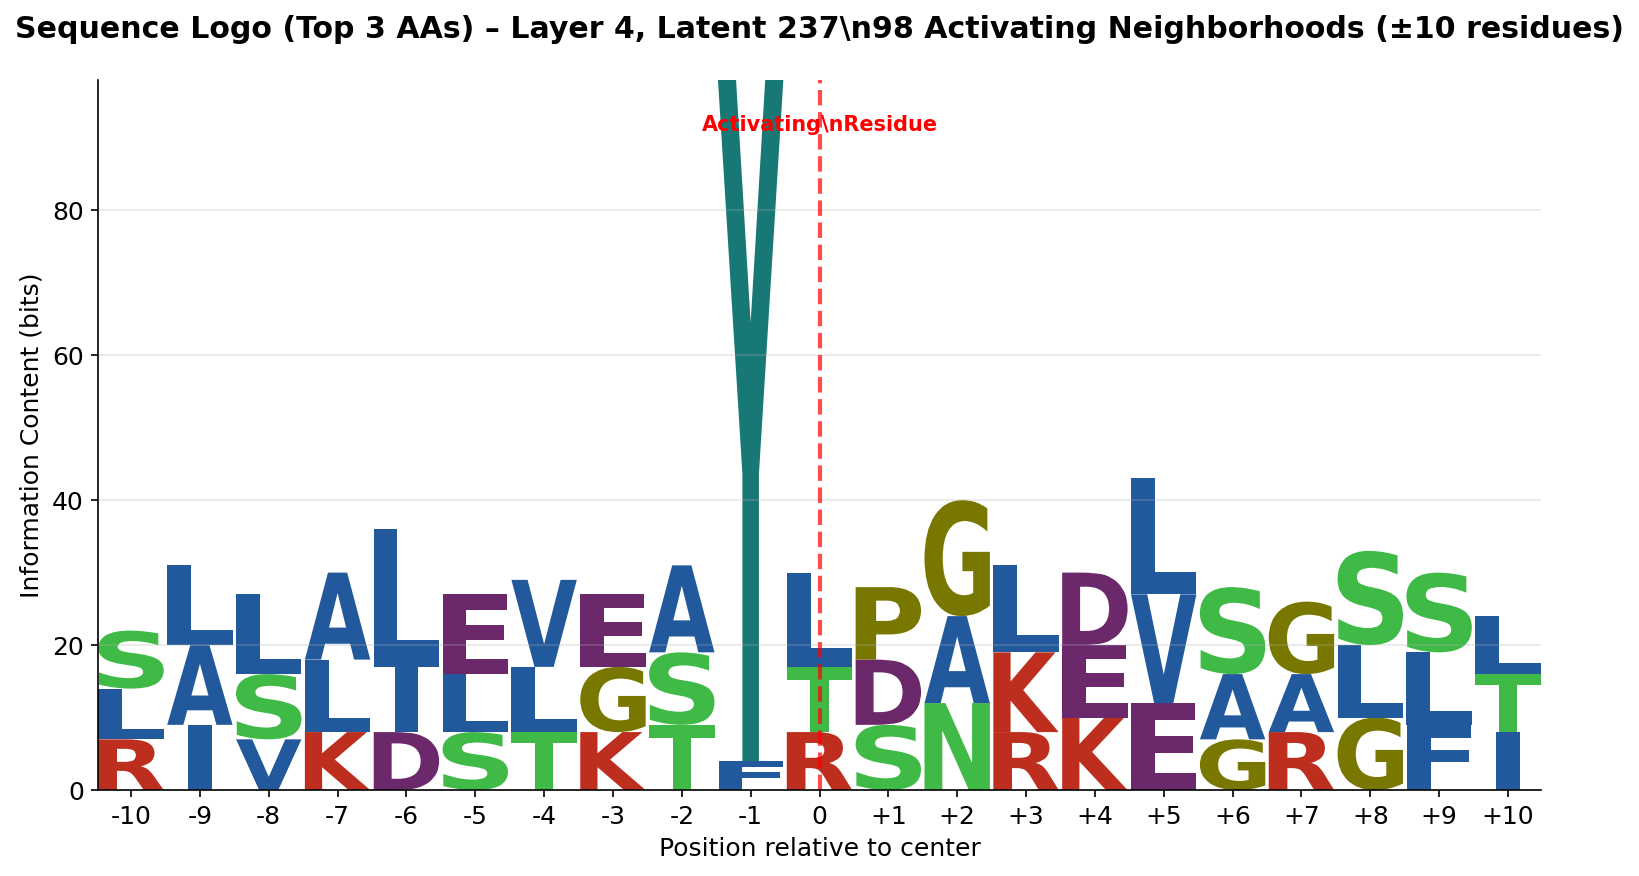

✅ Generated logo for layer 4, latent 237 with top 3 amino acids per position!


In [12]:
# Generate sequence logo with only top 3 amino acids per position
import matplotlib.pyplot as plt
import logomaker

if target_count_matrix is not None and not target_count_matrix.empty:
    print(f"Generating sequence logo for layer {target_layer}, latent {target_latent}...")
    print(f"Using top 3 amino acids per position")
    
    # -----------------------------------------------------------------------
    # Prepare data for logomaker (same as existing code)
    # -----------------------------------------------------------------------
    
    # transpose so rows = positions, columns = amino acids
    logo_df = target_count_matrix.T            # shape: (positions, 20 AA's)
    logo_df.index.name = 'pos'          # nice index name

    # make sure only standard AA columns remain & in canonical order
    aa_cols = list('ACDEFGHIKLMNPQRSTVWY')
    logo_df = logo_df.reindex(columns=aa_cols, fill_value=0)

    seq_len = len(logo_df)

    # -----------------------------------------------------------------------
    # Generate the plot
    # -----------------------------------------------------------------------
    plt.rcParams['figure.dpi']  = 150  # Lower DPI for notebook display
    plt.rcParams['font.size']   = 12

    fig, ax = plt.subplots(figsize=(max(8, seq_len * 0.5), 6))

    logomaker.Logo(
        logo_df,
        ax=ax,
        fade_below=0.5,
        stack_order='big_on_top',
        color_scheme='NajafabadiEtAl2017'
    )

    # x‑axis labels = relative positions
    rel_labels = [f'{i - window_size:+d}' if i != window_size else '0'
                  for i in range(seq_len)]

    ax.set_xticks(range(seq_len))
    ax.set_xticklabels(rel_labels)
    ax.set_xlabel('Position relative to center')
    ax.set_ylabel('Information Content (bits)')
    ax.set_title(
        f'Sequence Logo (Top 3 AAs) – Layer {target_layer}, Latent {target_latent}\\n'
        f'{len(target_aligned_sequences)} Activating Neighborhoods (±{window_size} residues)',
        pad=20, weight='bold'
    )

    # highlight centre residue
    ax.axvline(window_size, color='red', ls='--', lw=2, alpha=.7)
    ax.text(window_size, ax.get_ylim()[1]*0.95, 'Activating\\nResidue',
            ha='center', va='top', color='red', weight='bold', fontsize=10)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(True, axis='y', alpha=.3)
    fig.tight_layout()

    # Show the plot (don't save for now)
    plt.show()
    
    print(f"✅ Generated logo for layer {target_layer}, latent {target_latent} with top 3 amino acids per position!")

else:
    print("❌ No count matrix available to generate logo!")


Generating COMPRESSED sequence logo for layer 4, latent 237...


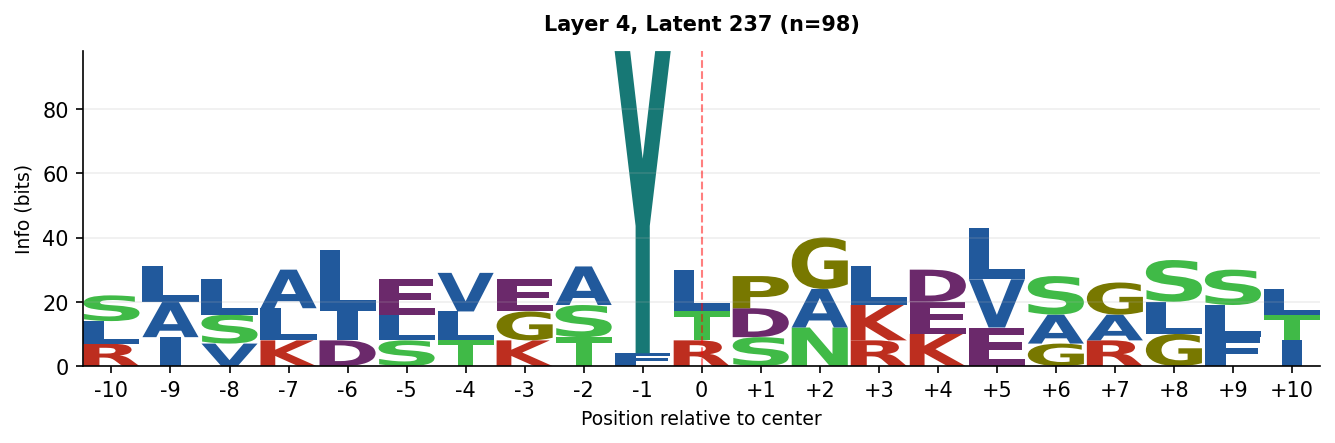

✅ Generated COMPRESSED logo suitable for stacking!
Figure height reduced to 3 inches for better stacking


In [20]:
# Generate compressed sequence logo suitable for stacking in research papers
import matplotlib.pyplot as plt
import logomaker

if target_count_matrix is not None and not target_count_matrix.empty:
    print(f"Generating COMPRESSED sequence logo for layer {target_layer}, latent {target_latent}...")
    
    # -----------------------------------------------------------------------
    # Prepare data for logomaker (same as before)
    # -----------------------------------------------------------------------
    logo_df = target_count_matrix.T
    logo_df.index.name = 'pos'
    aa_cols = list('ACDEFGHIKLMNPQRSTVWY')
    logo_df = logo_df.reindex(columns=aa_cols, fill_value=0)
    seq_len = len(logo_df)

    # -----------------------------------------------------------------------
    # Generate COMPRESSED plot for stacking
    # -----------------------------------------------------------------------
    plt.rcParams['figure.dpi'] = 150
    plt.rcParams['font.size'] = 10  # Slightly smaller font

    # MUCH shorter figure height for stacking
    # fig, ax = plt.subplots(figsize=(max(6, seq_len * 0.4), 3))  # Height reduced from 6 to 3
    fig, ax = plt.subplots(figsize=(9, 3))
    logomaker.Logo(
        logo_df,
        ax=ax,
        fade_below=0.5,
        stack_order='big_on_top',
        color_scheme='NajafabadiEtAl2017'
    )

    # x‑axis labels = relative positions
    rel_labels = [f'{i - window_size:+d}' if i != window_size else '0'
                  for i in range(seq_len)]

    ax.set_xticks(range(seq_len))
    ax.set_xticklabels(rel_labels)
    ax.set_xlabel('Position relative to center', fontsize=9)
    ax.set_ylabel('Info (bits)', fontsize=9)  # Shorter y-label
    
    # FIX: Use proper newline instead of \\n
    ax.set_title(
        f'Layer {target_layer}, Latent {target_latent} (n={len(target_aligned_sequences)})',
        pad=10, weight='bold', fontsize=10
    )

    # Smaller, less prominent center line
    ax.axvline(window_size, color='red', ls='--', lw=1, alpha=.5)
    
    # Remove the "Activating Residue" text to save space
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(True, axis='y', alpha=.2)
    
    # Tighter layout
    fig.tight_layout()
    plt.subplots_adjust(top=0.85, bottom=0.15)  # Fine-tune spacing

    plt.show()
    
    print(f"✅ Generated COMPRESSED logo suitable for stacking!")
    print(f"Figure height reduced to 3 inches for better stacking")

else:
    print("❌ No count matrix available!")


In [15]:
seq_len * 0.4

8.4